<a href="https://colab.research.google.com/github/anura-g/models/blob/master/DCGAN_MNIST_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import random
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
#Defining variables

BATCH_SIZE = 200
img_size = 64
EPOCHS = 25
lr_G = 2e-3
lr_D = 2e-4
#size of latent vector z. 100 is used in most studies so i'm using it for now
nz = 100
#size of feature maps in generator
ngf = 128
#latent space
z_dim = 100
#Number of channels = nc, i.e. RGB
nc = 1
#size of feature maps in discriminator
ndf = 64
#beta1 for adam optimiser
beta1 = 0.5
#number of gpu's available
ngpu = 1

In [3]:
#DATA STUFF

#transforms data to tensor format
img_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#Download only training data and transform it to tensor format
dset = torchvision.datasets.MNIST('./NewData', download=True, train=True, transform=img_transform)

#We can iterate through this and train our data in batches
dataloader = torch.utils.data.DataLoader(dset, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

data_iter = iter(dataloader)

images, labels = data_iter.next()
test = images.view(images.size(0), -1)
print(test.size())

torch.Size([200, 4096])


In [4]:
print(images.size())

torch.Size([200, 1, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1652, 530)


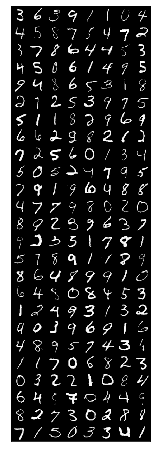

In [5]:
#Visualisng the data

def imshow(img):
  im = torchvision.utils.make_grid(img)
  npimg = im.cpu().numpy()
  print(npimg.shape)
  plt.figure(figsize=(8,8))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.xticks([])
  plt.yticks([])
  plt.show()

imshow(images)

In [0]:
#NOW DOING THE WEIGHT INTIALISATION
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
#Defining generator

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator,self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0),
      nn.BatchNorm2d(ngf * 8),
      nn.ReLU(True),
      # state size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),
      # state size. (ngf*4) x 8 x 8
      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),
      # state size. (ngf*2) x 16 x 16
      nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),
      # state size. (ngf) x 32 x 32
      nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
      nn.Tanh()
    
  
    )
  def forward(self, input):
    return self.model(input)
    


In [8]:
G = Generator(ngpu).to(device)
G
G.apply(init_weights)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [0]:
#Defining Discriminator

class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.model = nn.Sequential(

    nn.Conv2d(nc, ndf, 4, 2, 1),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
    nn.BatchNorm2d(ndf * 2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
    nn.BatchNorm2d(ndf * 4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),
    nn.BatchNorm2d(ndf * 8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(ndf * 8, 1, 4, 1, 0),
    nn.Sigmoid()   

    )

  def forward(self, input):
    return self.model(input)

In [10]:
D = Discriminator(ngpu).to(device)
D
D.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [0]:
#Loss function and optimiser
loss_function = nn.BCELoss()

num_batches_completed = 0
real_label = 1
fake_label = 0
fixed_noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
G_solver = optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, 0.999))
D_solver = optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, 0.999))

Starting Training Loop...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 0, D_Loss: 1.279416561126709, G_Loss: 1.160394310951233
(3, 1652, 530)


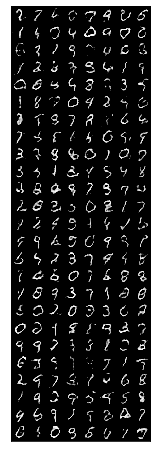

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1, D_Loss: 1.7087129354476929, G_Loss: 0.36671730875968933
(3, 1652, 530)


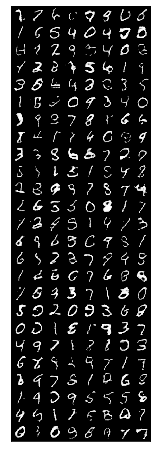

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2, D_Loss: 1.3873927593231201, G_Loss: 0.5957839488983154
(3, 1652, 530)


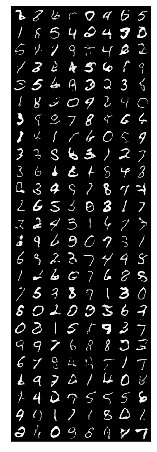

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3, D_Loss: 1.3185516595840454, G_Loss: 0.7540111541748047
(3, 1652, 530)


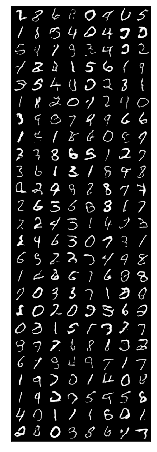

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4, D_Loss: 1.2198972702026367, G_Loss: 1.185589075088501
(3, 1652, 530)


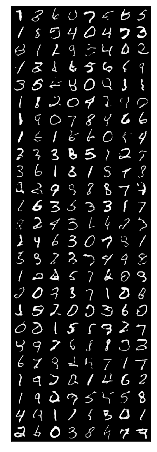

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5, D_Loss: 1.0146286487579346, G_Loss: 1.4337996244430542
(3, 1652, 530)


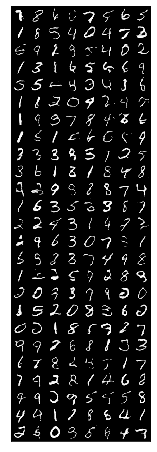

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 6, D_Loss: 1.1720095872879028, G_Loss: 2.492271661758423
(3, 1652, 530)


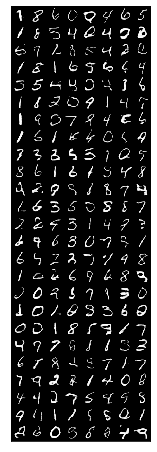

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7, D_Loss: 1.227874517440796, G_Loss: 1.2021644115447998
(3, 1652, 530)


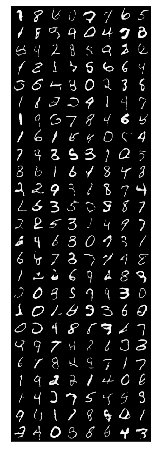

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8, D_Loss: 0.6198064684867859, G_Loss: 2.1980631351470947
(3, 1652, 530)


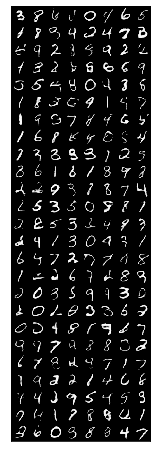

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9, D_Loss: 1.4922871589660645, G_Loss: 0.95965176820755
(3, 1652, 530)


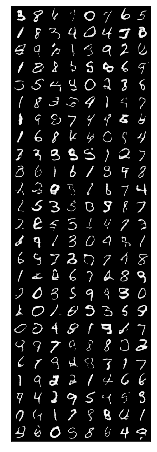

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10, D_Loss: 1.9481539726257324, G_Loss: 4.396733283996582
(3, 1652, 530)


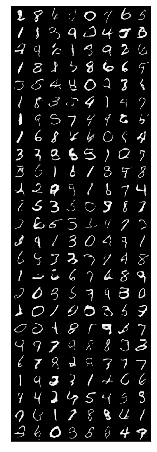

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11, D_Loss: 1.1234830617904663, G_Loss: 1.847649097442627
(3, 1652, 530)


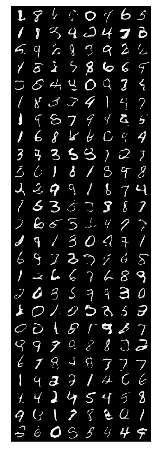

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12, D_Loss: 0.12150561809539795, G_Loss: 2.9341135025024414
(3, 1652, 530)


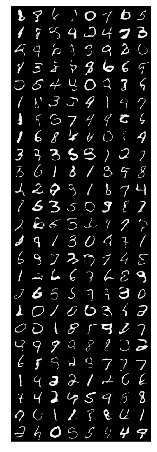

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 13, D_Loss: 1.9415394067764282, G_Loss: 0.19668743014335632
(3, 1652, 530)


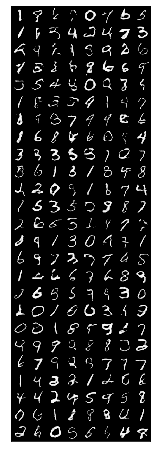

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 14, D_Loss: 0.05251172557473183, G_Loss: 5.396624565124512
(3, 1652, 530)


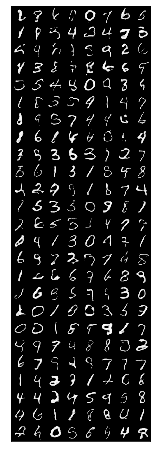

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15, D_Loss: 0.7669538259506226, G_Loss: 4.248262882232666
(3, 1652, 530)


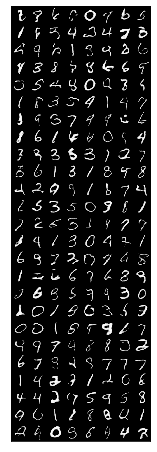

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 16, D_Loss: 0.3574102222919464, G_Loss: 2.7881970405578613
(3, 1652, 530)


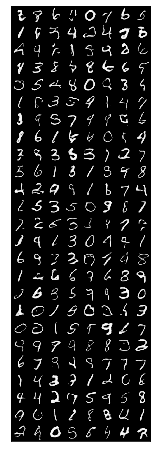

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 17, D_Loss: 0.9698238372802734, G_Loss: 1.597307562828064
(3, 1652, 530)


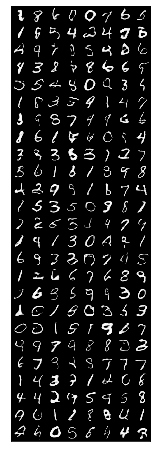

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 18, D_Loss: 0.16480572521686554, G_Loss: 3.9581353664398193
(3, 1652, 530)


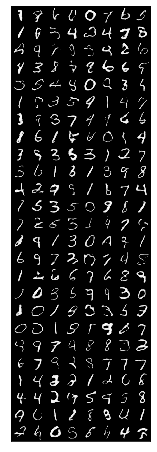

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 19, D_Loss: 0.6688377857208252, G_Loss: 1.9784283638000488
(3, 1652, 530)


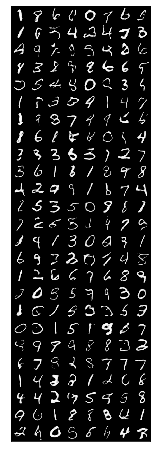

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20, D_Loss: 1.016903281211853, G_Loss: 0.8953301310539246
(3, 1652, 530)


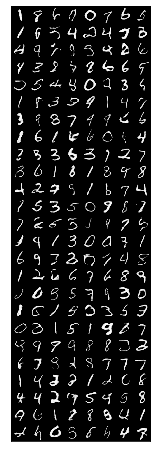

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 21, D_Loss: 2.7120230197906494, G_Loss: 1.807256817817688
(3, 1652, 530)


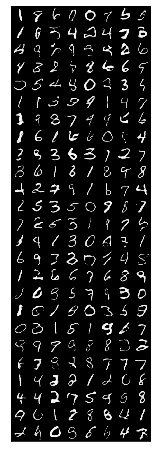

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 22, D_Loss: 0.8048019409179688, G_Loss: 2.6977128982543945
(3, 1652, 530)


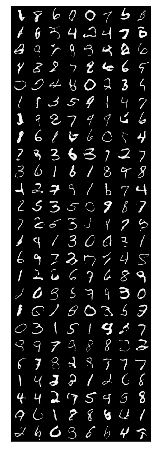

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 23, D_Loss: 0.05357091873884201, G_Loss: 4.262744426727295
(3, 1652, 530)


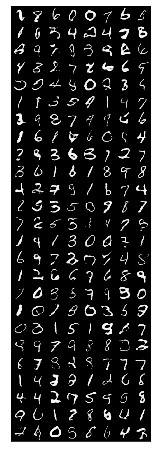

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 24, D_Loss: 0.2513206899166107, G_Loss: 4.237918853759766
(3, 1652, 530)


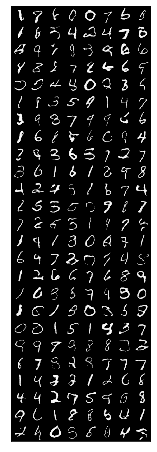

In [12]:
# Training Loop

# Lists to keep track of progress
G_loss_avg = 0.0
D_loss_avg = 0.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
  counter = 0
  # For each batch in the dataloader
  for image_batch, data in dataloader:
    
    #Train with real
    D.zero_grad()

    label = torch.full((BATCH_SIZE,), real_label, device=device)

    output = D(image_batch.to(device))
    errD_real = loss_function(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    #Train with fake
    noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
    fake = G(noise)
    label.fill_(fake_label)
    output = D(fake.detach())
    errD_fake = loss_function(output, label)
    errD_fake.backward()

    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    D_solver.step()

    #Update G network

    G.zero_grad()
    label.fill_(real_label)
    output = D(fake)
    errG = loss_function(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    G_solver.step()

    counter += 1

    #print(epoch, counter, len(dataloader), errD.item(), errG.item())
          

  with torch.no_grad():
    print("Epoch: {}, D_Loss: {}, G_Loss: {}".format(epoch, errD.item(), errG.item()))
    samples = G(fixed_noise).detach()
    samples = samples.view(samples.size(0), 1, img_size, img_size)
    imshow(samples)
     
